# Spotify KNeighbors Analysis - Artist Recommender 🎧 <a class='tocSkip'>"

# Introduction

This is a notebook trying to find you the best alternatives to your favorite musician. The input data is a list of about 30,000 artists from all over the world defined by their most common style features. <br>
In the first half of the notebook (3, 4) the data is described and visualized. The second part (5ff) is dealing with a simple KNeighborsRegressor model from Scikit Learn to define the nearest neighbors of the given artists in the data set. Finally, there is a recommender to return the most similar artists for a queried musician.<br>

The recommender is also pushed to production to try it without the notebook. You can find it here (Heroku): [The Artist Recommender](https://artist-recommender.herokuapp.com/). The app is run on a Streamlit Framework and hosted by heroku. Longer _loading times might_ occur.

# Imports 📚

In [174]:
# TABLES & VIS
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from ast import literal_eval
import numpy as np

# NLTK
import regex as re
import unicodedata

# ML
from sklearn.neighbors import KNeighborsRegressor
from joblib import dump, load
import pickle

# The Dataset 👨‍💻

The data set I am working on is provided on [Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=data_by_artist_o.csv).<br>
- It has a total of ~29,000 artists and their audio features.
- It is a grouped data set from a bigger set of tracks. The features are aggregated by mean (for numerical) and mode (for categorical values). 

In [2]:
df = pd.read_csv('../raw_data/data_by_artist_o.csv')
df.shape

(28680, 16)

In [3]:
# a glance at the data set
df.sample(5)

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
16514,[],Matt Ward,0.013400,0.747000,218640.000000,0.736000,0.000036,0.095000,-4.274000,0.133000,169.171000,0.583000,43.000000,9,1,1
20466,['mantra'],Ravindra Sathe,0.974000,0.305000,406812.000000,0.102000,0.000000,0.275000,-17.324000,0.039400,111.587000,0.110000,0.000000,6,1,2
14554,"['alternative metal', 'hardcore', 'rap rock']",Life Of Agony,0.001700,0.258000,114680.000000,0.928000,0.003400,0.375000,-5.098000,0.106000,163.580000,0.353000,43.000000,2,1,2
11444,[],Jararaca E Ratinho,0.935111,0.696556,166469.111111,0.488000,0.171049,0.184489,-11.243111,0.192667,109.220667,0.901667,0.000000,7,1,18
7703,['classical tenor'],Ernst Haefliger,0.976538,0.331308,270423.692308,0.185392,0.000175,0.246038,-16.210308,0.050323,126.405308,0.171469,0.846154,0,1,13


In [4]:
df.dtypes
# data types seem to be correctly evaluated

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

# Provided Features 🎼

## Overview

In [5]:
print(f'The data set has the following features provided \n{list(df.columns)}')

The data set has the following features provided 
['genres', 'artists', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'key', 'mode', 'count']


In [6]:
print(f'The data set has {(df.dtypes != "object").sum()} numerical features')

The data set has 14 numerical features


In [7]:
df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
count,28680.000000,28680.000000,2.868000e+04,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000
mean,0.498373,0.546490,2.388780e+05,0.497488,0.174756,0.202441,-11.140498,0.094014,115.844830,0.512723,34.060945,5.412901,0.759170,13.847211
std,0.370614,0.176474,1.211318e+05,0.254885,0.298406,0.140884,5.771749,0.111986,25.003834,0.244421,22.376438,3.480552,0.427595,53.372544
min,0.000000,0.000000,1.879550e+04,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.122296,0.431000,1.823304e+05,0.283568,0.000004,0.110362,-13.972292,0.039200,99.366500,0.329000,12.000000,2.000000,1.000000,2.000000
50%,0.478458,0.557000,2.186400e+05,0.504000,0.001880,0.161000,-10.088938,0.052200,115.357400,0.523243,39.000000,6.000000,1.000000,3.000000
75%,0.896000,0.675000,2.684670e+05,0.702783,0.215291,0.247000,-6.889000,0.095300,129.848750,0.703000,51.000000,8.000000,1.000000,8.000000
max,0.996000,0.986000,5.403500e+06,1.000000,1.000000,0.991000,1.342000,0.964000,217.743000,0.991000,93.000000,11.000000,1.000000,3169.000000


**Note**<br>
All features besides ```loudness```,  ```key``` and ```popularity``` are scaled from 0 to 1. <br>
- ```loudness``` is represented in a range from -60 to 1.34, measured in dB. The lower number represents _higher_ volumes.
- ```key``` is a range from 0 to 11 (meaning from the note C to H)
- ```popularity``` seems to be in a range of 0 to 100 with a highest rating of 93 points.

## Feature relation

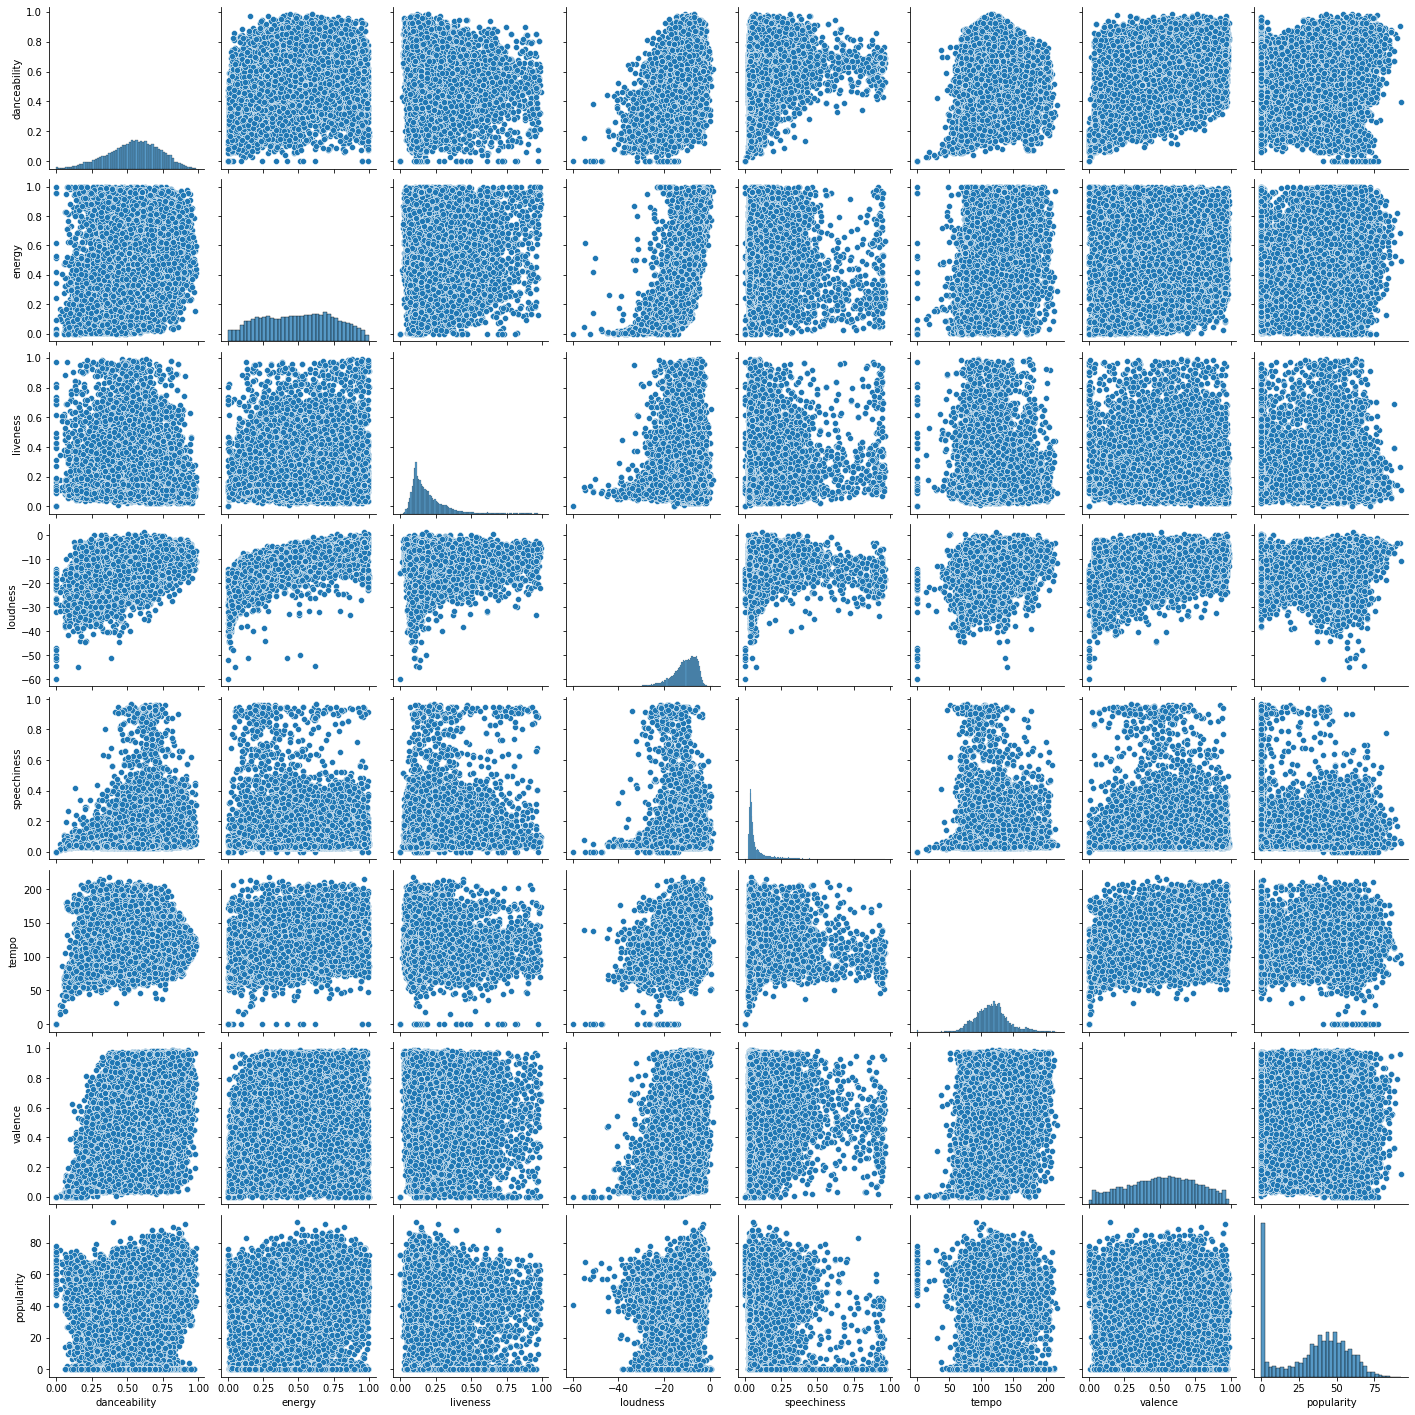

In [8]:
# Pairplot to inspect the correlations between the features
# removing features which don't seem to have any descriptive correlation or are the counterparts of other features
## such as acousticness<>speachiness
pair = sns.pairplot(df.drop(columns=['genres', 
                                     'artists', 
                                     'count', 
                                     'mode', 
                                     'key', 
                                     'duration_ms', 
                                     'instrumentalness',
                                     'acousticness']))
pair

**Note**<br>
We can see a slight positive correlation between the following features over the whole data set:<br>
- ```valence``` vs. ```loudness```
- ```danceability``` vs. ```loudness```
- ```danceability``` vs. ```speachiness```
- ```danceability``` vs. ```tempo```

There is no main factor for an artist to **be popular.** Although, more speachiness is more likely to achieve less popularity.  

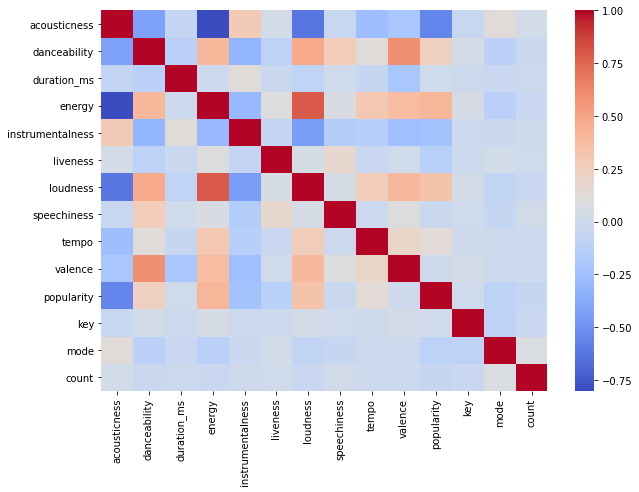

In [9]:
# Another way of analysing correlations - The Heatmap
corr = df.corr()
plt.figure(figsize=(10,7))
heatmap = sns.heatmap(corr, cmap='coolwarm')

## Feature distributions

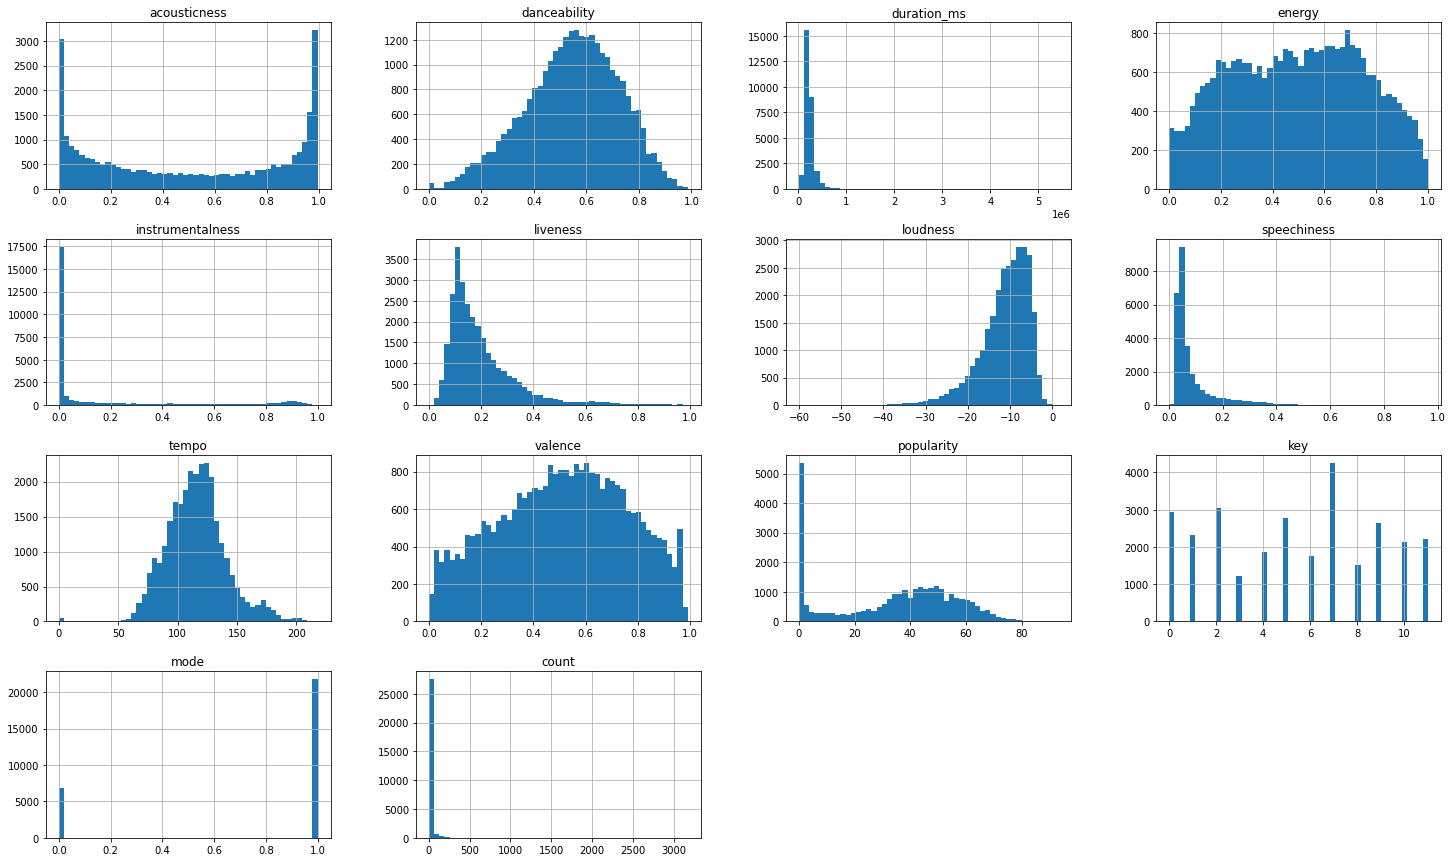

In [10]:
# Plotting distributions
df.hist(bins=50, figsize=(25,15))
plt.show()

**Note**<br>
- ```liveness``` is skewed to the right => most songs don't show much liveness
- ```loudness``` is skewed to the left => songs are usually more silent
- ```key``` 'G' is used the most under all the given artists (check further analysis on that)
- ```instrumentalness``` seems to be having a lot of non-instrumental artists (e.g. audio books).

... _lets analyze the keys and modes a bit more_

In [11]:
# Joining the key and mode together to have them plotted separately
key_mode = pd.DataFrame()
semi = ['C', 'Csharp', 'D', 'Dsharp', 'E', 'F', 'Fsharp', 'G', 'Gsharp', 'A', 'Asharp', 'H', 'C']
minmaj = {0.0:'min', 1.0:'maj'}

In [12]:
key_mode['mode_str'] = df['mode'].replace(minmaj)
key_mode['key_str'] =  df['key'].apply(lambda x: semi[x])
key_mode['key_mode'] = key_mode['key_str'] + '_' + key_mode['mode_str']

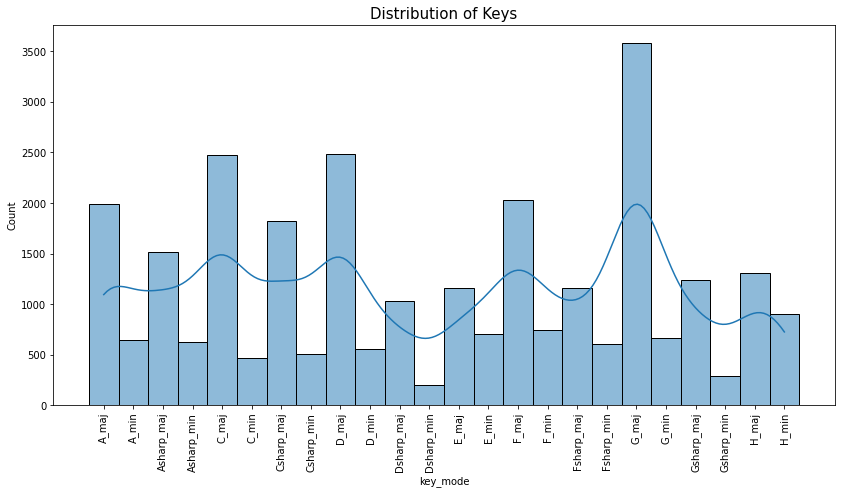

In [13]:
plt.figure(figsize=(14,7))
sns.histplot(key_mode['key_mode'].sort_values(), kde=True)
plt.xticks(rotation=90)
plt.title('Distribution of Keys', size=15)
plt.show()

**Note**<br>
```Gsharp_maj``` appears to be the most common key by far among the artists. This may derive from its unique harmony and easy playability (on a guitar 🎸 e.g.).

In [14]:
# unpacking all the genres in the lists of genres
genres = pd.DataFrame()
genres['genres'] = df.genres.apply(lambda x: literal_eval(x))
avail_genres = []
for lst in genres.genres:
    lst = [x.replace(' ', '_') for x in lst]
    _ = [avail_genres.append(x) for x in lst if len(lst) > 0]

In [15]:
# getting the count per genre
counts = {i:avail_genres.count(i) for i in avail_genres}
genres_ = pd.DataFrame.from_dict(counts, 
                                 orient='index', 
                                 columns=['count']).sort_values(by='count', 
                                                                ascending=False)

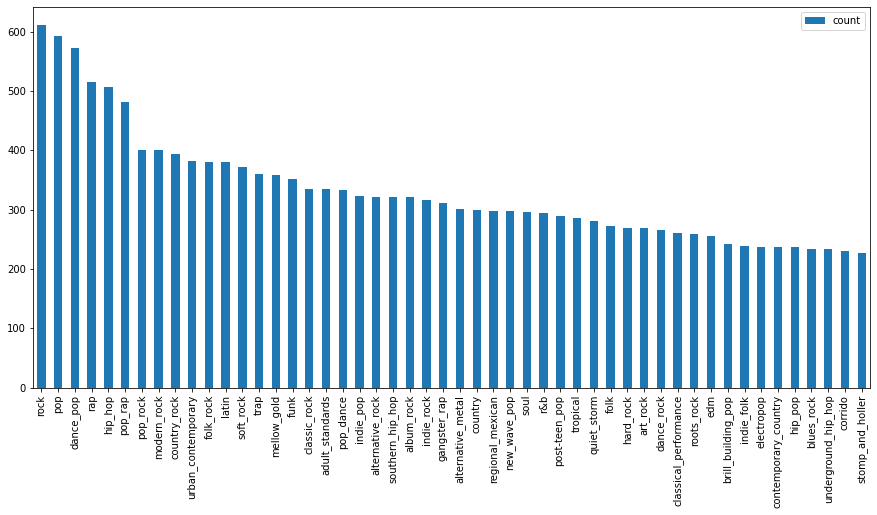

In [16]:
# plotting the 50 most important genres
genres_.head(50).plot(kind='bar', figsize=(15,7))
plt.xticks(rotation=90)
plt.show()

In [17]:
print(f'The 5 most common genres among the artists are \n{list(genres_.head(5).index)}')
print(f'\nIn total there are \033[1m{genres_.shape[0]} available genres\033[0m')

The 5 most common genres among the artists are 
['rock', 'pop', 'dance_pop', 'rap', 'hip_hop']

In total there are 2972 available genres


## Missing Values

In [18]:
# checking for NaNs
print(f'There are {sum(df.isnull().sum())} NaN values in the data set')

There are 0 NaN values in the data set


In [19]:
# Inspecting genres
print(f'Although, there are some empty genre lists: {sum([len(list(x)) == 0 for x in df["genres"]])} in the rows')

Although, there are some empty genre lists: 0 in the rows


 A total of 5349 entries have 0 instrumentalness


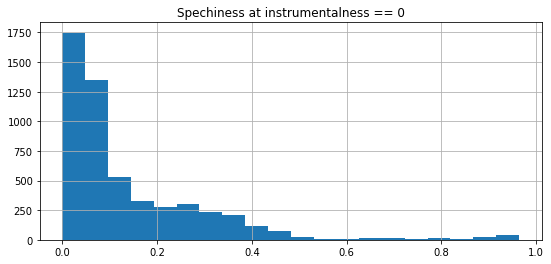

In [20]:
# Inspecting instrumentalness
df[df['instrumentalness']==0]['speechiness'].hist(figsize=(9,4), bins=20)
plt.title('Spechiness at instrumentalness == 0')
print(f' A total of {df[df["instrumentalness"]==0].shape[0]} entries have 0 instrumentalness')
plt.show()

**Note**<br>
The theory of audio books from [section 4.3](#Feature-distributions) as being complementary to low instrumentalness couldn't be verified. I suggest, we have missing values here.

In [21]:
# inspecting popularity
print(f'A total of {df[df["popularity"]==0].shape[0]} entries have 0 popularity')

A total of 4368 entries have 0 popularity


**Summary**<br>
Missing values at features ```genres```, ```instrumentalness```, ```popularity``` should be either imputed or dropped from the data set in order not to have an unbalanced and biased model.

# Preprocessing ⚙️

## Genres

Looking at the ```genres``` feature I see some potential to implement it in the data set. However, they are not correctly displayed and therefore have to be encoded in separate columns.

In [22]:
# Copying to have easy access to original values
df_enc = df.copy()

In [23]:
# populating the top 50 genres as OHE in df_enc
# non appearing values will be filled with 'rock'
top_50 = genres_.head(50).index
def OHE_genres(df=df_enc, top_50=top_50, fillna='rock'):
    df_cop = df.copy()
    df_cop[top_50] = 0
    for c, row in df_cop.iterrows():
        for i in top_50:
            if i in row['genres']:
                df_cop.loc[c, i] = 1
        if all(row[top_50] == 0):
            df_cop.loc[c, fillna] = 1
            
    return df_cop 

In [24]:
df_enc = OHE_genres()

In [25]:
pd.set_option('display.max_columns', None)
df_enc.head(5)

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,rock,pop,dance_pop,rap,hip_hop,pop_rap,pop_rock,modern_rock,country_rock,urban_contemporary,folk_rock,latin,soft_rock,trap,mellow_gold,funk,classic_rock,adult_standards,pop_dance,indie_pop,alternative_rock,southern_hip_hop,album_rock,indie_rock,gangster_rap,alternative_metal,country,regional_mexican,new_wave_pop,soul,r&b,post-teen_pop,tropical,quiet_storm,folk,hard_rock,art_rock,dance_rock,classical_performance,roots_rock,edm,brill_building_pop,indie_folk,electropop,contemporary_country,hip_pop,blues_rock,underground_hip_hop,corrido,stomp_and_holler
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Popularity

Although we have a lot of missing ```popularity``` entries, I would like to keep the feature in the data set. The recommender should have the ability to recommend artists which are similarly popular.

In [26]:
# replacing with the median (distribution is quite normal)
median_pop = df_enc[df_enc['popularity'] > 0].popularity.median()
df_enc['popularity'] = df_enc.popularity.replace(0.0, median_pop)

In [27]:
df_enc.popularity.min()

0.0097087378640776

## Instrumentalness

About 65% of the ```instrumentalness``` feature close to 0 (<0.1). The feature will be dropped. All imputation attempts would lead to a biased model.

In [28]:
df_enc = df_enc.drop(columns='instrumentalness')

In [29]:
df_enc.head(3)

,genres,artists,acousticness,danceability,duration_ms,energy,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,rock,pop,dance_pop,rap,hip_hop,pop_rap,pop_rock,modern_rock,country_rock,urban_contemporary,folk_rock,latin,soft_rock,trap,mellow_gold,funk,classic_rock,adult_standards,pop_dance,indie_pop,alternative_rock,southern_hip_hop,album_rock,indie_rock,gangster_rap,alternative_metal,country,regional_mexican,new_wave_pop,soul,r&b,post-teen_pop,tropical,quiet_storm,folk,hard_rock,art_rock,dance_rock,classical_performance,roots_rock,edm,brill_building_pop,indie_folk,electropop,contemporary_country,hip_pop,blues_rock,underground_hip_hop,corrido,stomp_and_holler
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Target

**Note**<br>
For the artist recommender we only want to find out the vicinity of artists to each other. Therefore we won't need a ```target```.

In [30]:
df_enc['target'] = 0

In [31]:
# saving for the app
df_enc.to_csv('../raw_data/preprocessed.csv')

In [32]:
df_enc.drop(columns=['artists', 'genres', 'target']).shape

(28680, 63)

# Model 🦿

Lets have a very easy Kmeans model to define the artists which are lying close to each other measured by the given input features. 

In [33]:
# Define X and y
X = df_enc.drop(columns=['artists', 'genres', 'target']) # Remove non numerical features
y = df_enc['target']

knn_model = KNeighborsRegressor().fit(X, y) # Instanciate and train model
# save the model for production
dump(knn_model, '../model.joblib')

['../model.joblib']

# Recommender 🐣

In [34]:
def normalize(inpt):
    """
    removing interpunction, trimming whitespaces and replacing spacial chars with their nearest relatives.
    inpt: a string you wish to normalize.
    returns: the normalized string.
    """
    reg = re.sub(r'[^\w\s]', ' ', inpt.lower())
    white = re.sub(r'\s+', ' ', reg)
    uni = unicodedata.normalize('NFKD', white).encode('ascii','ignore').decode('utf8')
    return uni

In [35]:
def finder(artist, data=df_enc):
    """
    will find your favourite artist in a given dataframe under the column name 'artist'.
    Pass the artist name (str) and the data frame (pd.DataFrame).
    returns: a pd.DataFrame containing the row of your searched artist
    """
    df_cop = data.copy()
    df_cop['artists'] = df_cop.artists.apply(lambda x: normalize(x))
    artist = normalize(artist)
    print(f'looking for normalized term {artist}')
    try:
        # try to find the whole search term in artists via bool indexing
        ix = df_cop.artists[df_cop.artists == artist].index[0]
        print('found via bool indexing')
        return pd.DataFrame(df_cop.loc[ix,:]).T
    except:
        # tokenize search term
        search = artist.split(' ')
        # get index of searched term
        ixs = []
        for i, row in df_cop.iterrows():
            splt = row['artists'].lower().split(' ')
            found = [x in splt for x in search]
            if sum(found) >= len(found)/2:
                ixs.append(i)
        if len(ixs) > 0:
            print('found alternatives via tokenized search')
            print(f'did you mean...')
            return list(df_cop.artists[ixs])
        else:
            print('could not find your artist. Please refine your search.')
            return 'please refine your search'

In [100]:
def recommend_artist(artist, model=knn_model, df=df_enc, neighbors=3):
    """
    will find the nearest neighbors of the desired artist.
    pass the ```artist```s name, the fitted ```model```, the n of ```neighbors``` and the pd.DataFrame (```df```) suiting the model.
    returns a list of recommended artists similar to the imput artist.
    """
    inpt = finder(artist, data=df)
    
    if isinstance(inpt, pd.DataFrame):
        X = inpt.drop(columns=['artists', 'genres', 'target'])
        # list neighbors
        dist, nearest = knn_model.kneighbors(X, n_neighbors=neighbors+1) # Return the distances and index of the 2 closest points
        indexes = nearest[0]
        dist = dist[0][1:]
        dist_fin = 1 - dist / (dist.max() + dist.max() / .2) # the highest distance in the set => beautifying the range
        
        return np.array(df.artists[indexes[1:]]), dist_fin # the nearest is always the artist itself
    else:
        print(inpt)

## Try it out

In [185]:
artist = input('Type your favoutite artist:')

Type your favoutite artist:jason derulo


In [186]:
reco, dist = recommend_artist(artist)

looking for normalized term jason derulo
found via bool indexing


Found these artists:


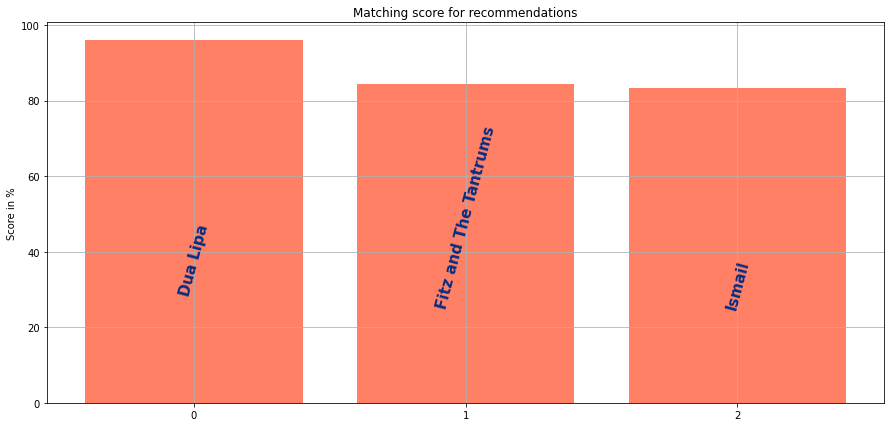

In [189]:
# show the matching of scores
plt.figure(figsize=(15,7))
plt.bar([0,1,2],height=dist*100, color='#ff8065')
for c, i in enumerate(np.array([dist, reco]).T):
    plt.text(x=c, y=i[0]*100*.3, s=i[1], ha='center', rotation=75, size=15, color='#042d85', weight='demi')
plt.xticks([0,1,2])
plt.grid()
plt.title('Matching score for recommendations')
plt.ylabel('Score in %')
print('Found these artists:')
plt.show()
# showing the matching score of the artist to be similar (score is beautified, but relative)

**Note**<br>
The **recommender** is case, special-char and interpunction insensitive and therefore quite stable for a small project like this. Although it will only recognize fully written words and not auto-fill them (like 'Emine' or 'beatle'). Try it out yourself and have fun! 🥁

**Try it out online**<br>
[THE SPOTIFY RECOMMENDER APP](https://artist-recommender.herokuapp.com/)